# 差分の差分法

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
np.random.seed(1)

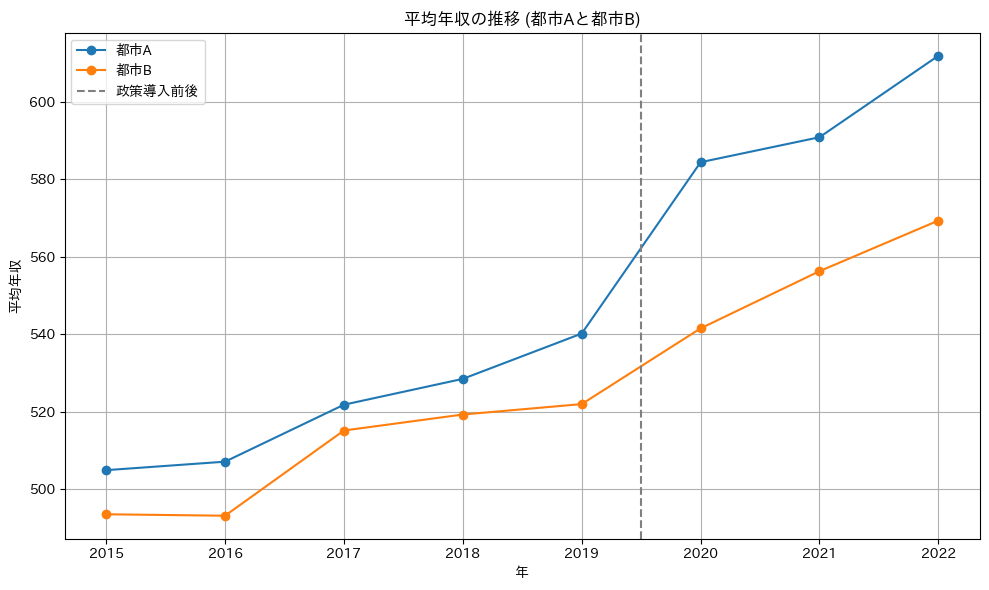

In [3]:
years = np.arange(2015, 2023)
cities = ['都市A', '都市B']
num_employees_per_city = 50

data = []
employee_id = 0

# 各都市の従業員を生成
for city in cities:
    for emp in range(num_employees_per_city):
        base_income = np.random.normal(500, 50)  # 各従業員の基礎収入
        for year in years:
            time_trend = (year - 2015) * 10  # 共通の時系列トレンド
            policy_effect = 0
            if city == '都市A' and year >= 2020:
                policy_effect = 40  # 政策効果
            noise = np.random.normal(0, 50)  # 年ごとのノイズ
            income = base_income + time_trend + policy_effect + noise
            treated = 1 if city == '都市A' else 0
            post = 1 if year >= 2020 else 0
            data.append({
                'employee_id': employee_id,
                'year': year,
                'city': city,
                'income': income,
                'treated': treated,
                'post': post
            })
        employee_id += 1

df = pd.DataFrame(data)

# 都市ごとの年次平均収入をプロット
avg_df = df.groupby(['city', 'year'])['income'].mean().reset_index()

plt.figure(figsize=(10, 6))
for city in cities:
    subset = avg_df[avg_df['city'] == city]
    plt.plot(subset['year'], subset['income'], marker='o', label=city)
plt.axvline(2019.5, color='gray', linestyle='--', label='政策導入前後')
plt.title('平均年収の推移 (都市Aと都市B)')
plt.xlabel('年')
plt.ylabel('平均年収')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show();


In [4]:
# 差分の差分法を回帰分析で実行
model = smf.ols('income ~ treated * post', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     53.24
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           2.29e-31
Time:                        15:53:28   Log-Likelihood:                -4559.7
No. Observations:                 800   AIC:                             9127.
Df Residuals:                     796   BIC:                             9146.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      508.6176      4.584    110.964   

# Sharp RDD

In [6]:
# サンプルサイズ
N = 1000

# 割当変数（試験点数）
X = np.random.uniform(40, 80, N)

# 閾値（奨学金の基準）
threshold = 60

# 処置（奨学金の受給）: Sharp RDD
T = (X >= threshold).astype(int)

# 真の因果効果
tau = 0.5

# 潜在的GPA
Y0 = 2.0 + 0.05 * (X - threshold) + np.random.normal(0, 0.3, N)  # 奨学金なし
Y1 = Y0 + tau                                                     # 奨学金あり

# 観測されるGPA
Y = Y0 + T * tau

# データフレーム化
df = pd.DataFrame({
    'X': X,
    'T': T,
    'Y': Y
})

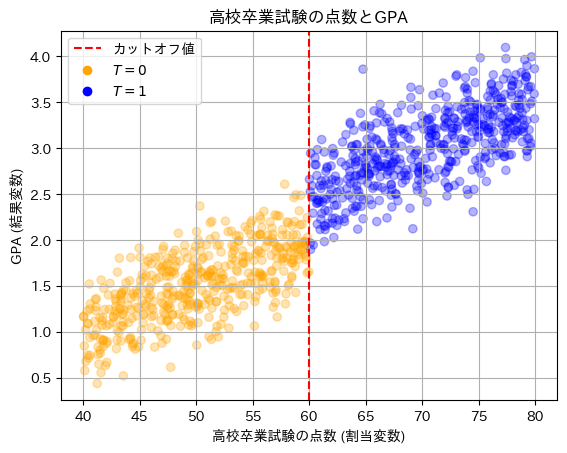

In [7]:
colors = ['orange' if t == 0 else 'blue' for t in df['T']]
plt.scatter(df['X'], df['Y'], c=colors, alpha=0.3)
plt.axvline(threshold, color='red', linestyle='--', label='カットオフ値')
plt.xlabel("高校卒業試験の点数 (割当変数)")
plt.ylabel("GPA (結果変数)")
plt.title("高校卒業試験の点数とGPA")
plt.legend()
plt.grid(True)
# 凡例のためのダミー（T=0, T=1）
plt.scatter([], [], c='orange', label=r'$T=0$')
plt.scatter([], [], c='blue', label=r'$T=1$')
plt.legend()
plt.show();

In [8]:
# Bandwidth選択（ここでは5点以内のデータのみ使用）
h = 5
df_local = df[np.abs(df['X'] - threshold) <= h]

# 左側と右側で局所平均を計算
mean_left = df_local[df_local['X'] < threshold]['Y'].mean()
mean_right = df_local[df_local['X'] >= threshold]['Y'].mean()

late_np = mean_right - mean_left
print(f"ノンパラメトリックによるLATE推定（バンド幅±{h}）: {late_np:.3f}")

ノンパラメトリックによるLATE推定（バンド幅±5）: 0.755


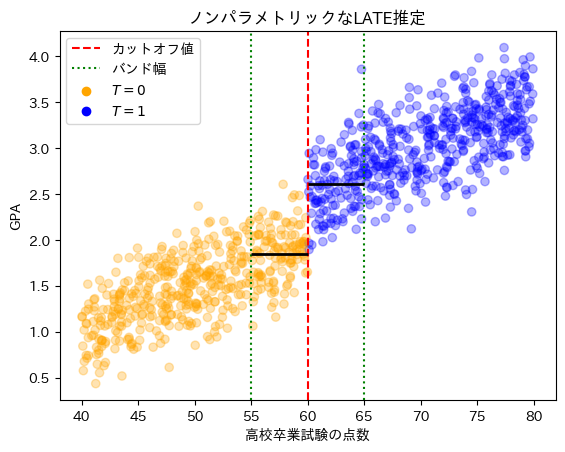

In [9]:
colors = ['orange' if t == 0 else 'blue' for t in df['T']]
plt.scatter(df['X'], df['Y'], c=colors, alpha=0.3)
plt.axvline(threshold, color='red', linestyle='--', label='カットオフ値')
plt.axvline(threshold - h, color='green', linestyle=':', label='バンド幅')
plt.axvline(threshold + h, color='green', linestyle=':')
plt.hlines(mean_left, threshold - h, threshold, color='black', linewidth=2)
plt.hlines(mean_right, threshold, threshold + h, color='black', linewidth=2)
plt.title("ノンパラメトリックなLATE推定")
plt.xlabel("高校卒業試験の点数")
plt.ylabel("GPA")
# 凡例のためのダミー（T=0, T=1）
plt.scatter([], [], c='orange', label=r'$T=0$')
plt.scatter([], [], c='blue', label=r'$T=1$')
plt.legend();

In [10]:
# 閾値との差を説明変数にする

# 回帰モデル: Y = α + δT + βR + ε
model = smf.ols("Y ~ T + X", data=df).fit()
print(model.summary())

late_lr = model.params['T']
print(f"\n線形回帰によるLATE推定値: {late_lr:.3f}")

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     3521.
Date:                Mon, 15 Sep 2025   Prob (F-statistic):               0.00
Time:                        15:56:12   Log-Likelihood:                -214.18
No. Observations:                1000   AIC:                             434.4
Df Residuals:                     997   BIC:                             449.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9189      0.084    -10.896      0.0

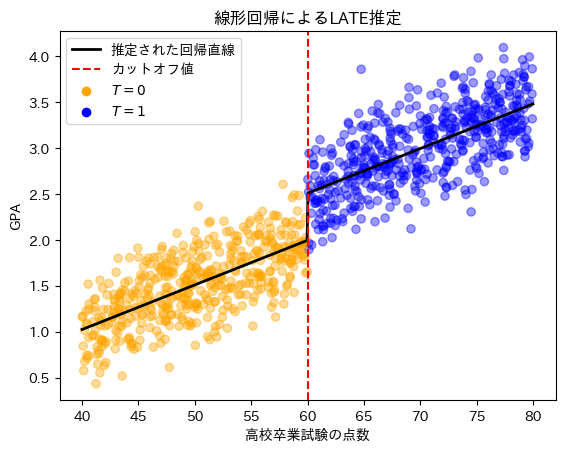

In [11]:
x_vals = np.linspace(40, 80, 500)
y_pred = model.params['Intercept'] + model.params['T'] * (x_vals >= threshold).astype(int) + model.params['X'] * x_vals
plt.scatter(df['X'], df['Y'], c=colors, alpha=0.4)
plt.plot(x_vals, y_pred, color='black', linewidth=2, label='推定された回帰直線')
plt.axvline(threshold, color='red', linestyle='--', label='カットオフ値')
plt.title("線形回帰によるLATE推定")
plt.xlabel("高校卒業試験の点数")
plt.ylabel("GPA")
# 凡例のためのダミー（T=0, T=1）
plt.scatter([], [], c='orange', label=r'$T=0$')
plt.scatter([], [], c='blue', label=r'$T=1$')
plt.legend();

In [12]:
# 回帰モデル: Y = α + δT + βR + γTR + ε
model = smf.ols("Y ~ T + X + T*X", data=df).fit()
print(model.summary())

late_lr = model.params['T'] + 60*model.params['T:X']
print(f"\n線形回帰によるLATE推定値: {late_lr:.3f}")

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     2346.
Date:                Mon, 15 Sep 2025   Prob (F-statistic):               0.00
Time:                        15:57:26   Log-Likelihood:                -213.95
No. Observations:                1000   AIC:                             435.9
Df Residuals:                     996   BIC:                             455.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8592      0.123     -6.993      0.0

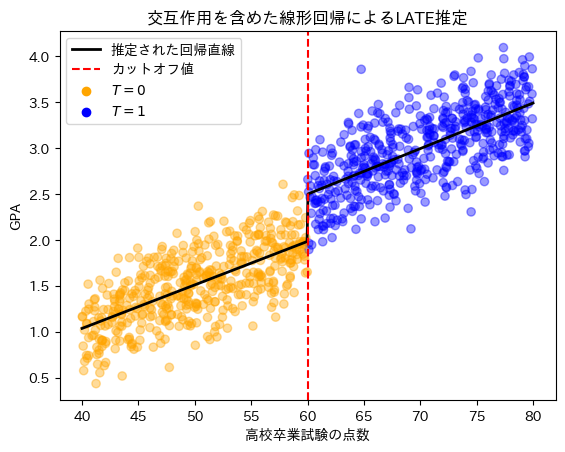

In [13]:
x_vals = np.linspace(40, 80, 500)
y_pred = model.params['Intercept'] + model.params['T'] * (x_vals >= threshold).astype(int) + model.params['X'] * x_vals + model.params['T:X'] * (x_vals >= threshold).astype(int) * x_vals
plt.scatter(df['X'], df['Y'], c=colors, alpha=0.4)
plt.plot(x_vals, y_pred, color='black', linewidth=2, label='推定された回帰直線')
plt.axvline(threshold, color='red', linestyle='--', label='カットオフ値')
plt.title("交互作用を含めた線形回帰によるLATE推定")
plt.xlabel("高校卒業試験の点数")
plt.ylabel("GPA")
# 凡例のためのダミー（T=0, T=1）
plt.scatter([], [], c='orange', label=r'$T=0$')
plt.scatter([], [], c='blue', label=r'$T=1$')
plt.legend();

# Fuzzy RDD

In [14]:
# データ生成：血圧に基づく生活改善指導プログラム
n = 1000
R = np.random.uniform(100, 180, n)  # 割り当て変数：血圧
Rc = 140                           # カットオフ点
Z = (R >= Rc).astype(int)          # ステップ関数

# 処置（T）：Z=0なら10%、Z=1なら60%の確率で参加
T_prob = np.where(Z == 1, 0.6, 0.1)
T = np.random.binomial(1, T_prob)

# 潜在的アウトカムと処置効果（+8）
Y0 = 50 - 0.1 * (R - 100) + np.random.normal(0, 3, n)
Y1 = Y0 + 8
Y = T * Y1 + (1 - T) * Y0

# データフレームに格納
df = pd.DataFrame({'R': R, 'Z': Z, 'T': T, 'Y': Y})

In [15]:
# -------------------------------
# 2段階最小二乗法による推定
# -------------------------------
# 第1段階：T ~ Z + R
X1 = sm.add_constant(df[['Z', 'R']])
first_stage = sm.OLS(df['T'], X1).fit()
df['T_hat'] = first_stage.predict(X1)

# 第2段階：Y ~ T_hat + R
X2 = sm.add_constant(pd.concat([df['T_hat'], df['R']], axis=1))
second_stage = sm.OLS(df['Y'], X2).fit()

second_stage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     43.36
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           8.78e-19
Time:                        15:58:39   Log-Likelihood:                -2892.0
No. Observations:                1000   AIC:                             5790.
Df Residuals:                     997   BIC:                             5805.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.4456      1.372     44.777      0.000      58.753      64.138
T_hat          8.8493      1.078      8.206      0.000       6.733      10.965
R             -0.1115      0.012     -9.308      0.000      -0.135      -0.088
==============================================================================
Omnibus:                        3.353   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.187   Jarque-Bera (JB):                3.188
Skew:                           0.091   Prob(JB):                        0.203
Kurtosis:                       2.792   Cond. No.                     1.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

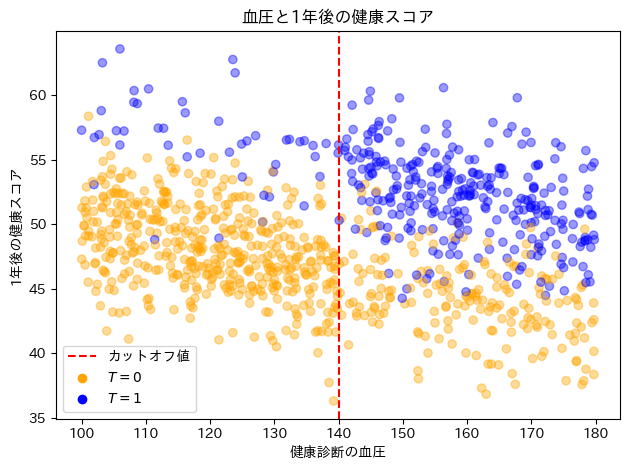

{'First Stage Coef (Z → T)': 0.5185746264940944, 'Second Stage Coef (T_hat → Y)': 8.849255159854577, 'LATE Estimate (2SLS)': 8.849255159854577}


In [17]:
# -------------------------------
# 結果の可視化
# -------------------------------
colors = ['orange' if t == 0 else 'blue' for t in df['T']]
plt.scatter(df['R'], df['Y'], c=colors, alpha=0.4)
plt.axvline(Rc, color='red', linestyle='--', label='カットオフ値')
plt.title('血圧と1年後の健康スコア')
plt.xlabel('健康診断の血圧')
plt.ylabel('1年後の健康スコア')
# 凡例のためのダミー（T=0, T=1）
plt.scatter([], [], c='orange', label=r'$T=0$')
plt.scatter([], [], c='blue', label=r'$T=1$')
plt.legend()
plt.tight_layout()
plt.savefig("図7.5.2_高解像度.png", dpi=600)
plt.show()
# -------------------------------
# 推定結果の出力
# -------------------------------
results = {
    'First Stage Coef (Z → T)': first_stage.params['Z'],
    'Second Stage Coef (T_hat → Y)': second_stage.params['T_hat'],
    'LATE Estimate (2SLS)': second_stage.params['T_hat']
}
print(results)